In [2]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import seaborn as sns
import time
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from IPython import display
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline as backend_inline

backend_inline.set_matplotlib_formats("svg")


#### Pytorch device specific configuration ###
# # Pytorch Gpu Configuration for Cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# For Directml Gpu Configurations
# import torch_directml

# device = torch_directml.device()

# Set default device
torch.set_default_device(device)

# # Font update global for all plots
# plt.rcParams.update({"font.size": 18})

In [ ]:
train_data_raw = np.loadtxt(open("../Datasets/mnist_train.csv", "rb"), delimiter=",")

train_data = train_data_raw[:, 1:]
train_labels = train_data_raw[:, 0]

In [28]:
# Data normalization
train_data_norm = train_data / np.max(train_data)
seven_idxs = np.where(train_labels == 7)[0]
not_seven_idxs = np.where(train_labels != 7)[0]

train_data = train_data_norm[not_seven_idxs]
test_data = train_data_norm[seven_idxs]
test_labels = np.ones(test_data.shape[0]) + 6
train_labels = train_labels[not_seven_idxs]
print(test_labels.shape, train_labels.shape)

(6265,) (53735,)


In [30]:
### Create train and test groups using dataloader
# Convert to tensor
train_data_tensor = torch.tensor(train_data).float()
train_labels_tensor = torch.tensor(train_labels).long()
test_data_tensor = torch.tensor(test_data).float()
test_labels_tensor = torch.tensor(test_labels).long()


# Convert into pytorch dataset
train_dataT = TensorDataset(train_data_tensor, train_labels_tensor)
test_dataT = TensorDataset(test_data_tensor, test_labels_tensor)

# Translate to dataloader objects
batchsize = 32
train_loader = DataLoader(
    train_dataT,
    batch_size=batchsize,
    shuffle=True,
    drop_last=True,
    generator=torch.Generator(device),
)
test_loader = DataLoader(
    test_dataT,
    batch_size=test_dataT.tensors[0].shape[0],
    generator=torch.Generator(device),
)

In [51]:
# Create the model function
def createNewMNISTNet(lr=0.01):
    # Model class
    class mnistNet(nn.Module):
        def __init__(self):
            super().__init__()

            # Input Layer
            self.input = nn.Linear(784, 64)

            # Hidden Layers
            self.hidden1 = nn.Linear(64, 32)
            self.hidden2 = nn.Linear(32, 32)

            # Output Layer
            self.output = nn.Linear(32, 10)

        # Forward Pass
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.hidden1(x))
            x = F.dropout(x, training=self.training)
            x = F.relu(self.hidden2(x))
            x = F.dropout(x, training=self.training)
            return self.output(x)

    # Model Instance
    net = mnistNet()
    # Loss Function
    lossFun = nn.CrossEntropyLoss()
    # Optimizer
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
    return net, lossFun, optimizer

In [52]:
# Function to train the model
nEpochs = 30


def trainTheModel():
    net, lossFun, optimizer = createNewMNISTNet(lr=0.01)

    # Initialize losses
    losses = torch.zeros(nEpochs)
    trainAcc = []
    # testAcc = []

    # The Loop
    for epoch in range(nEpochs):
        # Train Mode
        net.train()
        # Loop over batches
        batchAcc = []
        batchLoss = []

        for X, y in train_loader:

            # Forward Pass
            yHat = net(X)
            loss = lossFun(yHat, y)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Batch Loss
            batchLoss.append(loss.cpu().item())

            # Compute Batch Accuracy
            batchAcc.append(
                100 * torch.mean((torch.argmax(yHat, axis=1) == y).float()).cpu()
            )

        # End of batch Loop
        # Average Loss
        losses[epoch] = np.mean(batchLoss)
        trainAcc.append(np.mean(batchAcc))
    # End of epoch

    return trainAcc, losses, net

In [54]:
trainAcc, losses, net = trainTheModel()

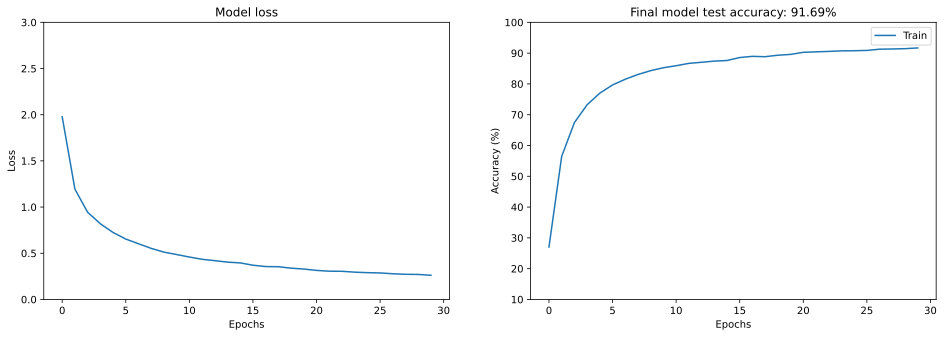

In [55]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(losses.cpu())
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].set_ylim([0, 3])
ax[0].set_title("Model loss")

ax[1].plot(trainAcc, label="Train")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy (%)")
ax[1].set_ylim([10, 100])
ax[1].set_title(f"Final model test accuracy: {trainAcc[-1]:.2f}%")
ax[1].legend()

plt.show()

In [56]:
# run the model through for the test data
X = next(iter(test_loader))[0]  # note: only need one output, hence the [0]
predictions = net(X).detach()

# save the model guesses
guesses = torch.argmax(predictions, axis=1).detach()

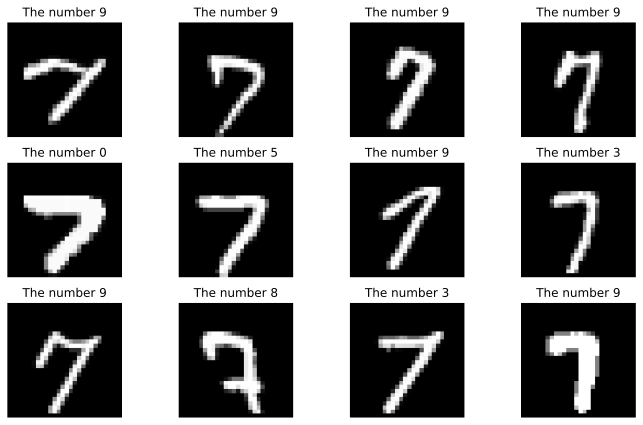

In [57]:
# show some 7's and their labels

fig, axs = plt.subplots(3, 4, figsize=(10, 6))

someRandom7s = np.random.choice(len(X), 12)

for i, ax in enumerate(axs.flatten()):

    thisimg = X[someRandom7s[i]].view(28, 28)
    ax.imshow(thisimg.cpu(), cmap="gray")
    ax.set_title(f"The number {guesses[ someRandom7s[i] ]}")
    ax.axis("off")

plt.tight_layout()
plt.show()

[0 1 2 3 4 5 6 8 9]


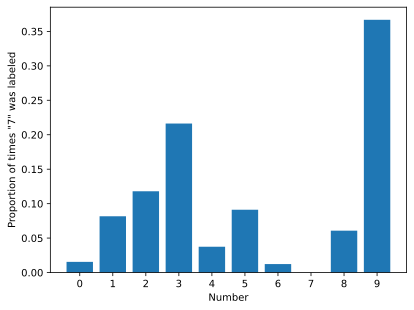

In [58]:
# which numbers are most likely to be confused with 7?
print(np.unique(guesses.cpu()))
net.eval()
probMistaken = np.zeros(10)

for i in range(10):
    probMistaken[i] = torch.mean((guesses == i).float())

plt.bar(range(10), probMistaken)
plt.xticks(range(10))
plt.xlabel("Number")
plt.ylabel('Proportion of times "7" was labeled')
plt.show()

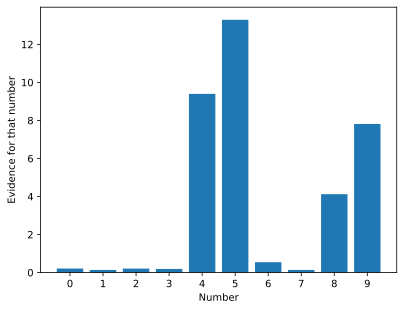

In [59]:
# Evidence for all numbers from one sample
sample2show = 30

plt.bar(range(10), torch.exp(predictions[sample2show]).cpu())
plt.xticks(range(10))
plt.xlabel("Number")
plt.ylabel("Evidence for that number")
plt.show()

In [60]:
# Function to check the test Accuracy
def testModePerformance(dataset):
    testAcc = []
    # Model in evaluation mode
    net.eval()

    for X, y in dataset:
        with torch.no_grad():
            yHat = net(X)
        testAcc.append(100 * (torch.argmax(yHat, axis=1) == y).float().cpu())

    return testAcc

np.mean(testModePerformance(test_loader))

0.0